# Implement U-net for Watermark Removal

In [1]:
import os
import random
import shutil
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

# set constants
SEED = 42
EPOCHS = 20
BATCH_SIZE = 32
EPSILON = 1e-4
LEARNING_RATE = 1e-4
BETA_VALUES = (0.9, 0.95)
DECAY_AFTER_ITERATIONS = 200000
DECAY_FACTOR = 0.5

IMAGE_LOGO_INSTANCES = 10
AUGMENTATION_STRATEGY = "r"

# change only the transparency
TRANSPARENCY = 0.65

# make the code deterministic
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# set a few settings
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

Using device: cuda


## Define the architecture

In [2]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.bottleneck = self.conv_block(512, 1024)

        self.dec4 = self.conv_block(1024 + 512, 512)
        self.dec3 = self.conv_block(512 + 256, 256)
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec1 = self.conv_block(128 + 64, 64)

        self.final_layer = nn.Conv2d(64, 3, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(nn.MaxPool2d(2)(e1))
        e3 = self.enc3(nn.MaxPool2d(2)(e2))
        e4 = self.enc4(nn.MaxPool2d(2)(e3))

        b = self.bottleneck(nn.MaxPool2d(2)(e4))

        d4 = self.dec4(torch.cat((nn.Upsample(scale_factor=2)(b), e4), dim=1))
        d3 = self.dec3(torch.cat((nn.Upsample(scale_factor=2)(d4), e3), dim=1))
        d2 = self.dec2(torch.cat((nn.Upsample(scale_factor=2)(d3), e2), dim=1))
        d1 = self.dec1(torch.cat((nn.Upsample(scale_factor=2)(d2), e1), dim=1))

        return self.final_layer(d1)

In [3]:
class UNetSmall(nn.Module):
    KERNEL_SIZE_CONV = 3
    KERNEL_SIZE_CONVT = 2
    STRIDE_CONVT = 2
    KERNEL_SIZE_MAX_POOLING = 2
    PADDING = "same"

    def __init__(self, unet_channels_in=3, unet_channels_out=3):
        super(UNetSmall, self).__init__()

        # encoder
        self.conv_relu_1 = self.conv_relu(unet_channels_in, 48)
        self.conv_relu_pooling_2 = self.conv_relu_pooling(48, 48)
        self.conv_relu_pooling_3 = self.conv_relu_pooling(48, 48)
        self.conv_relu_pooling_4 = self.conv_relu_pooling(48, 48)
        self.conv_relu_pooling_5 = self.conv_relu_pooling(48, 48)
        self.conv_relu_pooling_6 = self.conv_relu_pooling(48, 48)
        self.conv_relu_pooling_7 = self.conv_relu_pooling(48, 48)

        # bottleneck
        self.conv_relu_convt8 = self.conv_relu_convt(96, 96)

        # decoder
        self.conv_relu_9 = self.conv_relu(96, 96)
        self.conv_relu_convt10 = self.conv_relu_convt(144, 96)
        self.conv_relu11 = self.conv_relu(96, 96) # the dimensions are not mentioned in the paper
        self.conv_relu_convt12 = self.conv_relu_convt(144, 96)
        self.conv_relu13 = self.conv_relu(96, 96)
        self.conv_relu_convt14 = self.conv_relu_convt(144, 96)
        self.conv_relu15 = self.conv_relu(96, 96)
        self.conv_relu_convt16 = self.conv_relu_convt(144, 96)
        self.conv_relu17 = self.conv_relu(96, 96)
        self.conv_relu_convt18 = self.conv_relu_convt(99, 96)
        self.conv_relu19 = self.conv_relu(96, 64)
        self.conv_relu20 = self.conv_relu(64, 32)
        self.conv_leaky_relu21 = self.conv_leaky_relu(32, unet_channels_out)

    def conv_relu(self, channels_in, channels_out):
        return nn.Sequential(
            nn.Conv2d(
                channels_in,
                channels_out,
                kernel_size=UNetSmall.KERNEL_SIZE_CONV,
                padding=UNetSmall.PADDING
            ),
            nn.ReLU(inplace=True),
        )

    def conv_leaky_relu(self, channels_in, channels_out):
        return nn.Sequential(
            nn.Conv2d(
                channels_in,
                channels_out,
                kernel_size=UNetSmall.KERNEL_SIZE_CONV,
                padding=UNetSmall.PADDING
            ),
            nn.LeakyReLU(inplace=True),
        )

    def conv_relu_pooling(self, channels_in, channels_out):
        return nn.Sequential(
            nn.Conv2d(
                channels_in,
                channels_out,
                kernel_size=UNetSmall.KERNEL_SIZE_CONV,
                padding=UNetSmall.PADDING
            ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(UNetSmall.KERNEL_SIZE_MAX_POOLING),
        )

    def conv_relu_convt(self, channels_in, channels_out):
        return nn.Sequential(
            nn.Conv2d(
                channels_in,
                channels_out,
                kernel_size=UNetSmall.KERNEL_SIZE_CONV,
                padding=UNetSmall.PADDING
            ),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                channels_out,
                channels_out,
                kernel_size=UNetSmall.KERNEL_SIZE_CONVT,
                stride=UNetSmall.STRIDE_CONVT
            ),
        )

    def forward(self, x):
        # encoder
        enc1 = self.conv_relu_1(x)
        enc2 = self.conv_relu_pooling_2(enc1)
        enc3 = self.conv_relu_pooling_3(enc2)
        enc4 = self.conv_relu_pooling_4(enc3)
        enc5 = self.conv_relu_pooling_5(enc4)
        enc6 = self.conv_relu_pooling_6(enc5)
        enc7 = self.conv_relu_pooling_7(enc6)

        # decoder
        decoder8 = self.conv_relu_convt8(
            torch.cat(
                [
                    enc7,
                    F.interpolate(
                        enc6,
                        enc7.size()[2:],
                        mode="bilinear",
                        align_corners=True,
                    ),
                ],
                dim=1,
            )
        )
        decoder9 = self.conv_relu_9(decoder8)
        decoder10 = self.conv_relu_convt10(
            torch.cat(
                [
                    decoder9,
                    F.interpolate(
                        enc5, decoder9.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder11 = self.conv_relu11(decoder10)
        decoder12 = self.conv_relu_convt12(
            torch.cat(
                [
                    decoder11,
                    F.interpolate(
                        enc4, decoder11.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder13 = self.conv_relu13(decoder12)
        decoder14 = self.conv_relu_convt14(
            torch.cat(
                [
                    decoder13,
                    F.interpolate(
                        enc3, decoder13.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder15 = self.conv_relu15(decoder14)
        decoder16 = self.conv_relu_convt16(
            torch.cat(
                [
                    decoder15,
                    F.interpolate(
                        enc2, decoder15.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder17 = self.conv_relu17(decoder16)
        decoder18 = self.conv_relu_convt18(
            torch.cat(
                [
                    decoder17,
                    F.interpolate(
                        x, decoder17.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder19 = self.conv_relu19(decoder18)
        decoder20 = self.conv_relu20(decoder19)

        return self.conv_leaky_relu21(decoder20)


## Load images

In [4]:
class OxfordPetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row["image_path"])
        label = int(row["class"]) - 1  # Subtract 1 to make classes zero-indexed

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4784, 0.4460, 0.3960], std=[0.2245, 0.2216, 0.2227]),
    ]
)


### Load images with watermarks

In [5]:
trainval_data_w_watermark = (
    pd.read_csv(f"./data/pet_dataset_info_{IMAGE_LOGO_INSTANCES}{AUGMENTATION_STRATEGY}{TRANSPARENCY}.csv")
    .query("fold == 'trainval'")
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
test_data_w_watermark = (
    pd.read_csv(f"./data/pet_dataset_info_5x{TRANSPARENCY}.csv")
    .query("fold == 'test'")
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)

train_loader_w_watermark = DataLoader(
    OxfordPetDataset(trainval_data_w_watermark, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_loader_w_watermark = DataLoader(
    OxfordPetDataset(test_data_w_watermark, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=False,
)


In [6]:
def calculate_mean_std(loader):
    # this method is used to compute the mean and std for the dataset without logos
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, _ in tqdm(loader):
        batch_samples = images.size(0) 
        images = images.view(batch_samples, images.size(1), -1) 

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std

### Load images without watermarks

In [7]:
trainval_data_wo_watermark = trainval_data_w_watermark.copy(deep=True)
test_data_wo_watermark = test_data_w_watermark.copy(deep=True)

trainval_data_wo_watermark["image_path"] = trainval_data_wo_watermark["image_path"].map(
    lambda x: x.replace(f"images_with_logos_{IMAGE_LOGO_INSTANCES}{AUGMENTATION_STRATEGY}{TRANSPARENCY}", "resized_images")[:-6] + ".jpg"
)
test_data_wo_watermark["image_path"] = test_data_wo_watermark["image_path"].map(
    lambda x: x.replace(f"images_with_logos_5x{TRANSPARENCY}", "resized_images")
)

train_loader_wo_watermark = DataLoader(
    OxfordPetDataset(trainval_data_wo_watermark, transform=transform), batch_size=BATCH_SIZE, shuffle=False
)
test_loader_wo_watermark = DataLoader(
    OxfordPetDataset(test_data_wo_watermark, transform=transform), batch_size=BATCH_SIZE, shuffle=False
)


## Train and test the network

### Define the loss, traning and test functions

In [8]:
class LADLoss(nn.Module):
    def __init__(self):
        super(LADLoss, self).__init__()

    def forward(self, predictions, targets):
        return torch.mean(torch.abs(predictions - targets))

In [9]:
class MSELoss(nn.Module):
    def __init__(self):
        super(MSELoss, self).__init__()

    def forward(self, predictions, targets):
        return torch.mean((predictions - targets) ** 2)

In [10]:
def train_watermark_removal_network(unet, train_loader_w_watermark, train_loader_wo_watermark, loss_fn):
    unet.train()

    with tqdm(total=len(train_loader_w_watermark)) as pbar:
        for (x_w_watermark, _), (x_wo_watermark, _) in zip(train_loader_w_watermark, train_loader_wo_watermark):
            pred = unet(x_w_watermark.to(DEVICE))

            loss = loss_fn(pred, x_wo_watermark.to(DEVICE))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss = loss.item()
            scheduler.step()
            pbar.update(1)

        print(f"train loss: {train_loss} ", end="")
        torch.save(unet.state_dict(), f"./models/watermark_removal_{IMAGE_LOGO_INSTANCES}{AUGMENTATION_STRATEGY}{TRANSPARENCY}.pth")

    return train_loss


In [11]:
def test_watermark_removal_network(unet, test_loader_w_watermark, test_loader_wo_watermark, loss_fn):
    unet.eval()

    test_loss = 0
    num_batches = len(test_loader_w_watermark)

    with tqdm(total=len(test_loader_w_watermark)) as pbar:
        with torch.no_grad():
            for (x_w_watermark, _), (x_wo_watermark, _) in zip(test_loader_w_watermark, test_loader_wo_watermark):
                pred = unet(x_w_watermark.to(DEVICE))
                test_loss += loss_fn(pred, x_wo_watermark.to(DEVICE)).item()
                pbar.update(1)

    print(f"test loss: {test_loss / num_batches}\n")

    return test_loss / num_batches


### Run the training and testing
After each epoch the model together with the loss are stored

In [12]:
results_path = f"./resources/results_{IMAGE_LOGO_INSTANCES}{AUGMENTATION_STRATEGY}{TRANSPARENCY}"
if os.path.exists(results_path):
    shutil.rmtree(results_path)

os.mkdir(results_path)

unet = UNet().to(DEVICE)
total_params = sum(layer.numel() for layer in unet.parameters())
print(f"The model has {total_params} parameters")

loss_fn = MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=LEARNING_RATE, betas=BETA_VALUES, eps=EPSILON)
scheduler = StepLR(optimizer, step_size=DECAY_AFTER_ITERATIONS // BATCH_SIZE, gamma=DECAY_FACTOR)

train_loss_values = []
test_loss_values = []

for epoch in range(EPOCHS):
    print(f"epoch {epoch + 1} / {EPOCHS}", end="")
    train_loss = train_watermark_removal_network(unet, train_loader_w_watermark, train_loader_wo_watermark, loss_fn)
    test_loss = test_watermark_removal_network(unet, test_loader_w_watermark, test_loader_wo_watermark, loss_fn)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    loss_values = pd.DataFrame(
        {"epoch": list(range(len(train_loss_values))), "train loss": train_loss_values, "test loss": test_loss_values}
    )
    loss_values.to_csv(f"{results_path}/watermark_removal_loss_evolution_{IMAGE_LOGO_INSTANCES}{AUGMENTATION_STRATEGY}{TRANSPARENCY}.csv", index=None)


The model has 31379075 parameters
epoch 1 / 20

100%|██████████| 1150/1150 [36:25<00:00,  1.77s/it]

train loss: 0.06624522060155869 

100%|██████████| 115/115 [01:27<00:00,  1.31it/s]


test loss: 0.053824999215810194

epoch 2 / 20

100%|██████████| 1150/1150 [35:10<00:00,  1.93s/it]

train loss: 0.06633149087429047 

100%|██████████| 115/115 [01:44<00:00,  1.10it/s]


test loss: 0.04554391477418982

epoch 3 / 20

100%|██████████| 1150/1150 [34:43<00:00,  1.75s/it]

train loss: 0.053282201290130615 

100%|██████████| 115/115 [01:23<00:00,  1.38it/s]


test loss: 0.03919758199025755

epoch 4 / 20

100%|██████████| 1150/1150 [34:31<00:00,  1.78s/it]

train loss: 0.04683710262179375 

100%|██████████| 115/115 [01:32<00:00,  1.24it/s]


test loss: 0.03207446534348571

epoch 5 / 20

100%|██████████| 1150/1150 [34:33<00:00,  1.77s/it]

train loss: 0.03566285967826843 

100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


test loss: 0.02811624764100365

epoch 6 / 20

100%|██████████| 1150/1150 [34:20<00:00,  1.77s/it]

train loss: 0.030983101576566696 

100%|██████████| 115/115 [01:32<00:00,  1.25it/s]


test loss: 0.02650045305490494

epoch 7 / 20

100%|██████████| 1150/1150 [34:56<00:00,  1.76s/it]

train loss: 0.02724642865359783 

100%|██████████| 115/115 [01:26<00:00,  1.33it/s]


test loss: 0.02385003344844217

epoch 8 / 20

100%|██████████| 1150/1150 [34:27<00:00,  1.77s/it]

train loss: 0.024287652224302292 

100%|██████████| 115/115 [01:29<00:00,  1.28it/s]


test loss: 0.022077720636582893

epoch 9 / 20

100%|██████████| 1150/1150 [34:12<00:00,  1.89s/it]

train loss: 0.022068943828344345 

100%|██████████| 115/115 [01:24<00:00,  1.35it/s]


test loss: 0.02165861531444218

epoch 10 / 20

100%|██████████| 1150/1150 [34:42<00:00,  1.80s/it]

train loss: 0.020257797092199326 

100%|██████████| 115/115 [01:33<00:00,  1.23it/s]


test loss: 0.020503728529033455

epoch 11 / 20

100%|██████████| 1150/1150 [36:25<00:00,  2.03s/it]

train loss: 0.018480641767382622 

100%|██████████| 115/115 [01:45<00:00,  1.09it/s]


test loss: 0.018174030826143595

epoch 12 / 20

100%|██████████| 1150/1150 [36:29<00:00,  1.77s/it]

train loss: 0.017373347654938698 

100%|██████████| 115/115 [01:37<00:00,  1.19it/s]


test loss: 0.01758040982581999

epoch 13 / 20

100%|██████████| 1150/1150 [37:20<00:00,  1.93s/it]

train loss: 0.016628287732601166 

100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


test loss: 0.017102586801933207

epoch 14 / 20

100%|██████████| 1150/1150 [36:21<00:00,  1.92s/it]

train loss: 0.01595723256468773 

100%|██████████| 115/115 [01:43<00:00,  1.11it/s]


test loss: 0.01673446128387814

epoch 15 / 20

100%|██████████| 1150/1150 [36:27<00:00,  1.88s/it]

train loss: 0.015336303971707821 

100%|██████████| 115/115 [01:41<00:00,  1.13it/s]


test loss: 0.01646239988343871

epoch 16 / 20

100%|██████████| 1150/1150 [36:05<00:00,  1.98s/it]

train loss: 0.014828329905867577 

100%|██████████| 115/115 [01:42<00:00,  1.12it/s]


test loss: 0.016251792831589347

epoch 17 / 20

100%|██████████| 1150/1150 [36:48<00:00,  1.95s/it]

train loss: 0.013822667300701141 

100%|██████████| 115/115 [01:42<00:00,  1.12it/s]


test loss: 0.016158960605769053

epoch 18 / 20

100%|██████████| 1150/1150 [36:36<00:00,  1.77s/it]

train loss: 0.013600897043943405 

100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


test loss: 0.016092825932023318

epoch 19 / 20

100%|██████████| 1150/1150 [36:16<00:00,  1.78s/it]

train loss: 0.01335691288113594 

100%|██████████| 115/115 [01:44<00:00,  1.11it/s]


test loss: 0.016008124225165534

epoch 20 / 20

100%|██████████| 1150/1150 [36:35<00:00,  2.03s/it]

train loss: 0.013121014460921288 

100%|██████████| 115/115 [01:37<00:00,  1.18it/s]

test loss: 0.01591979547039322



### Display and store the loss evolution

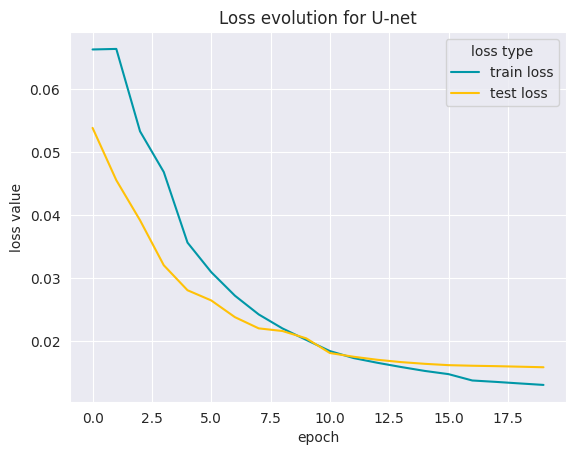

In [13]:
loss_values = (
    loss_values[["train loss", "test loss"]].melt().rename({"variable": "loss type", "value": "loss value"}, axis=1)
)
loss_values["epoch"] = 2 * list(range(loss_values.shape[0] // 2))

sns.lineplot(data=loss_values, x="epoch", y="loss value", hue="loss type", palette=["#0097A7", "#FFC107"])
plt.title("Loss evolution for U-net")
plt.savefig(f"{results_path}/loss_evolution_watermark_removal_{IMAGE_LOGO_INSTANCES}{AUGMENTATION_STRATEGY}{TRANSPARENCY}.png", dpi=200)
plt.show()


## Infer using the network
To use the network you need first to run the cells corresponding to imports, architecture definition and data loading

In [14]:
def inverse_normalize(tensor):
    # the images fed to the network have normalized pixels and this function applies the inverse operation so that the values are between 0 and 255
    mean = [0.4784, 0.4460, 0.3960]
    std = [0.2245, 0.2216, 0.2227]

    mean = torch.tensor(mean).reshape(1, 3, 1, 1)
    std = torch.tensor(std).reshape(1, 3, 1, 1)
    tensor = tensor * std + mean
    clipped_tensor = torch.clamp(tensor, min=0.0, max=1.0)

    return clipped_tensor

In [15]:
plt.style.use("default")

# load the network
loaded_unet = UNet()
loaded_unet.load_state_dict(torch.load(f"./models/watermark_removal_{IMAGE_LOGO_INSTANCES}{AUGMENTATION_STRATEGY}{TRANSPARENCY}.pth"))
loaded_unet.eval()
loaded_unet = loaded_unet.to(DEVICE)

# store in the lists below all the images from the test set as numpy arrays
images_with_watermark = []
images_cleaned = []
images_without_watermark = []

# removes the watermark from each test image and converts each image to a numpy array with values between 0 and 255
with torch.no_grad():
    for (x_w_watermark, _), (x_wo_watermark, _) in zip(test_loader_w_watermark, test_loader_wo_watermark):
        predicted_clean_images = loaded_unet(x_w_watermark.to(DEVICE))

        for image_with_watermark in x_w_watermark:
            images_with_watermark.append(
                np.transpose(inverse_normalize(image_with_watermark).cpu().numpy()[0], (1, 2, 0))
            )
        for image_without_watermark in x_wo_watermark:
            images_without_watermark.append(
                np.transpose(inverse_normalize(image_without_watermark).cpu().numpy()[0], (1, 2, 0))
            )
        for clean_image in predicted_clean_images:
            images_cleaned.append(np.transpose(inverse_normalize(clean_image.to("cpu")).cpu().numpy()[0], (1, 2, 0)))


### Display and store a set of image triplets (with watermark, cleaned, without watermark)

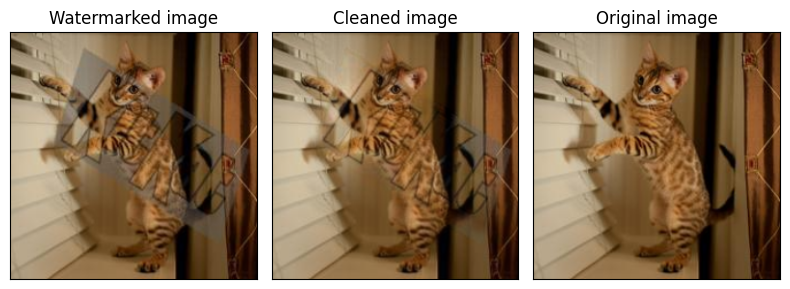

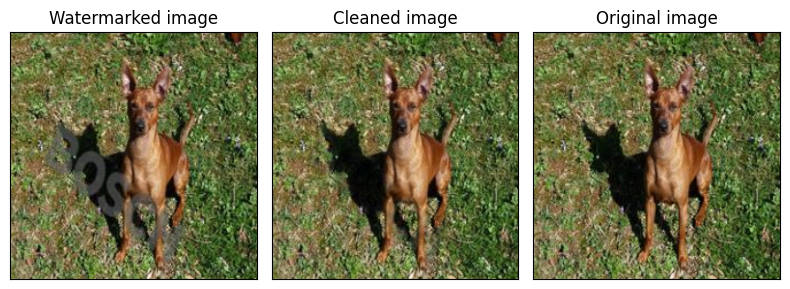

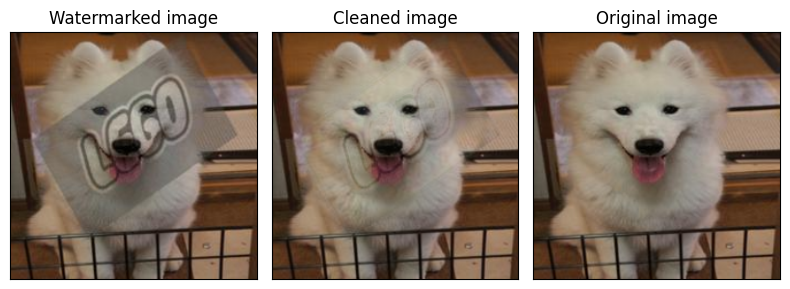

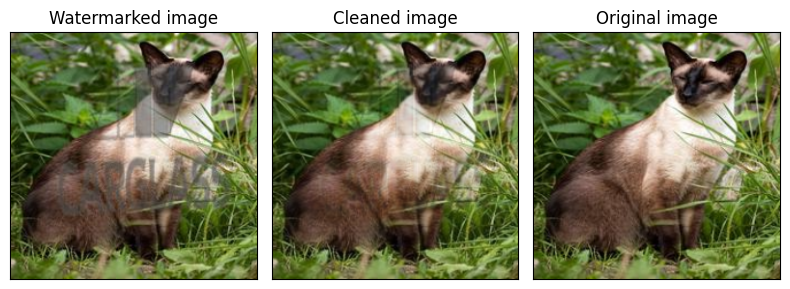

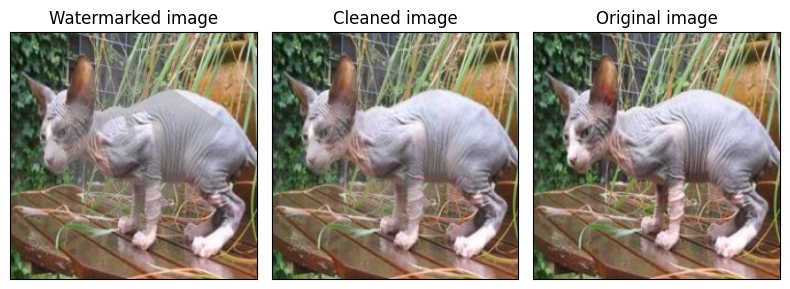

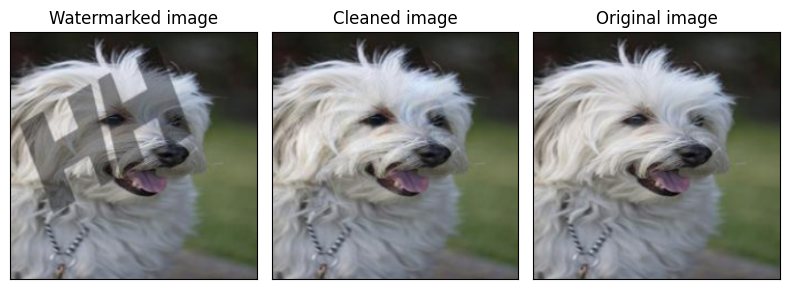

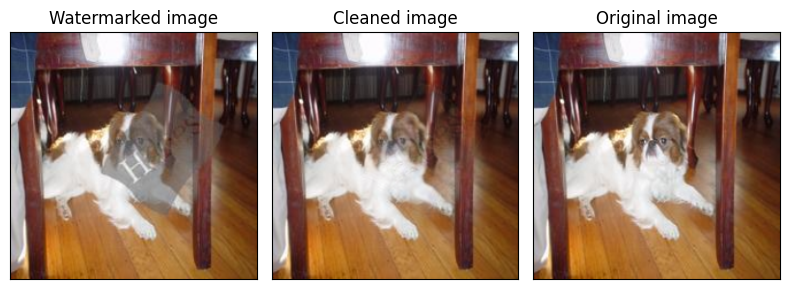

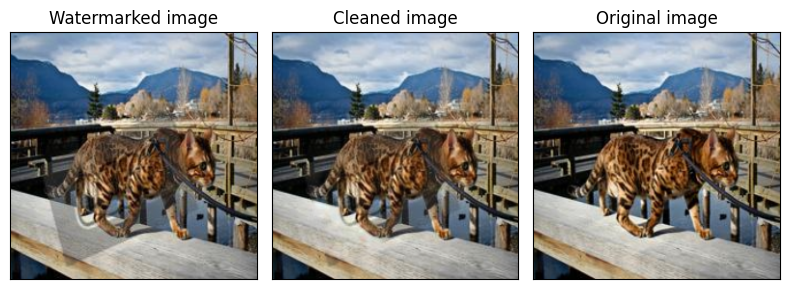

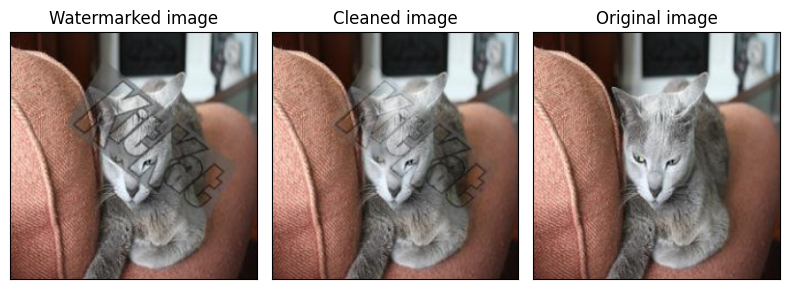

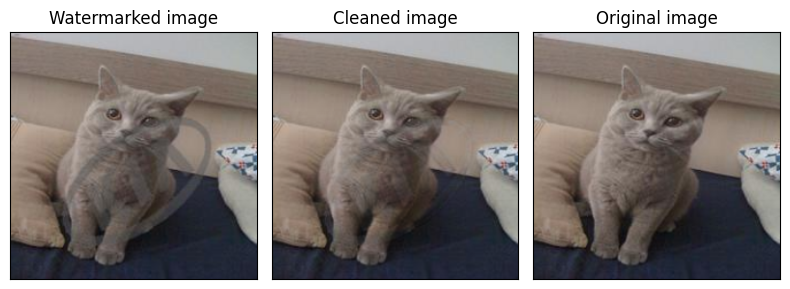

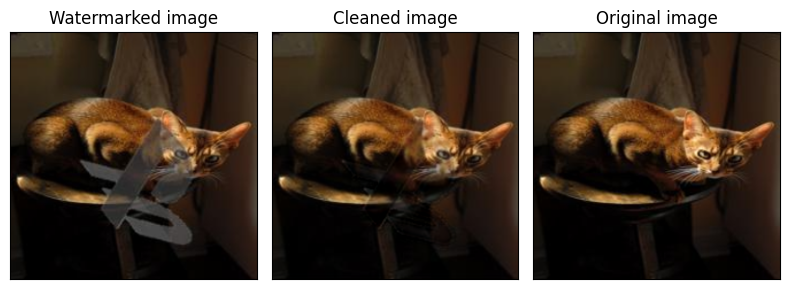

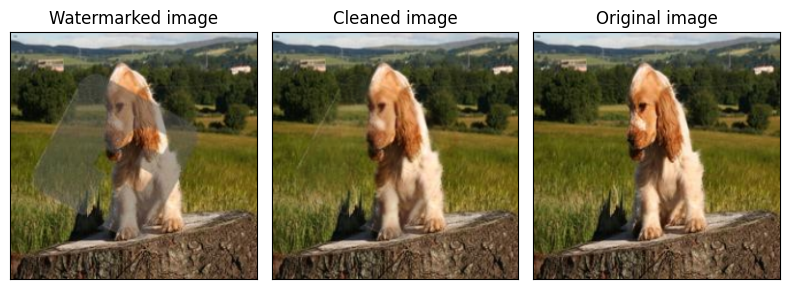

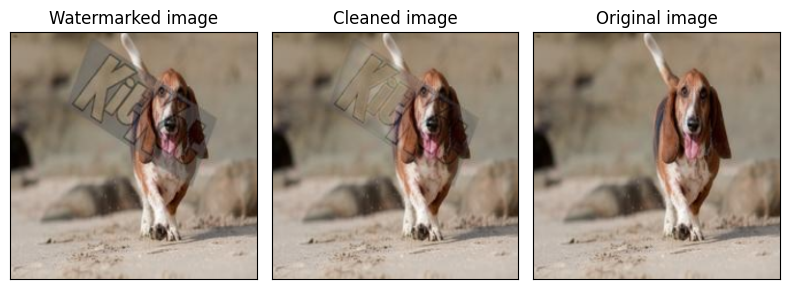

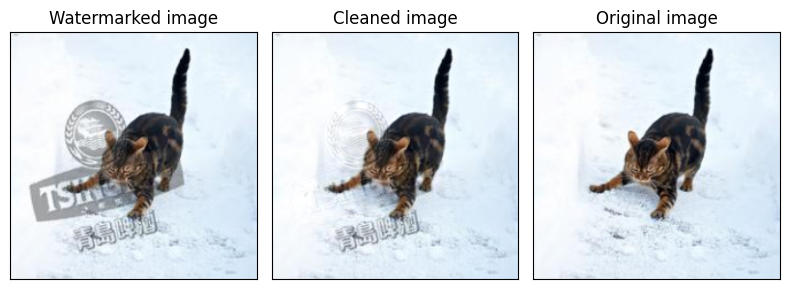

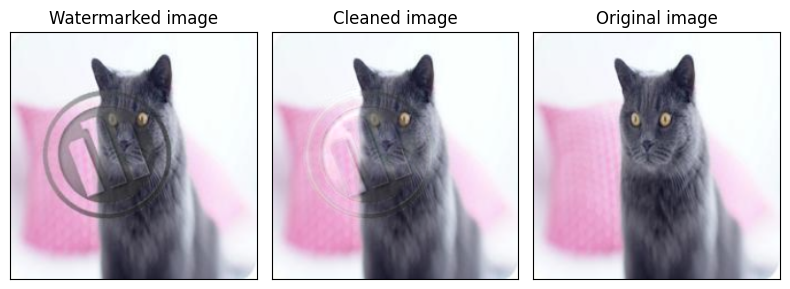

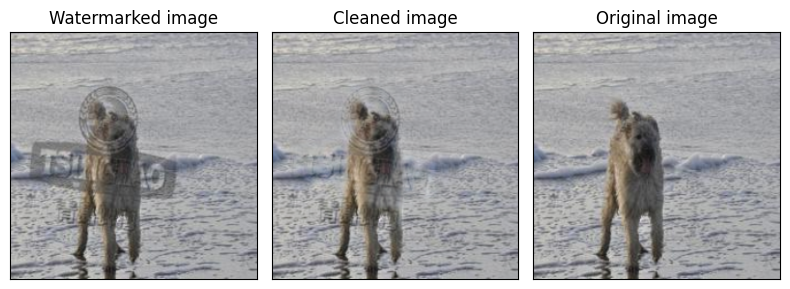

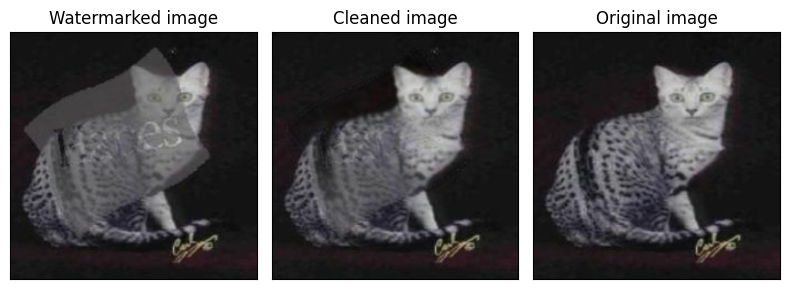

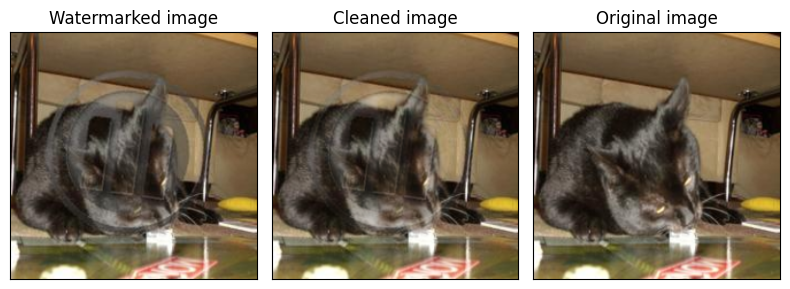

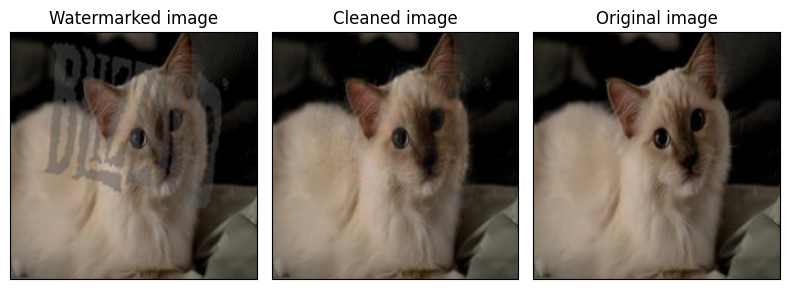

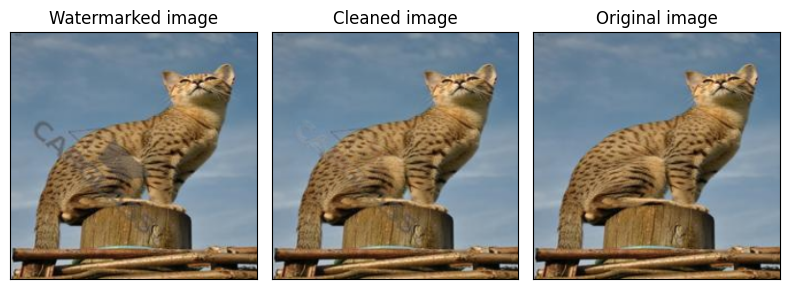

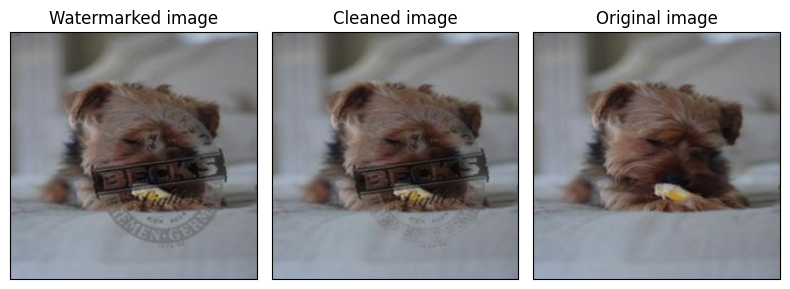

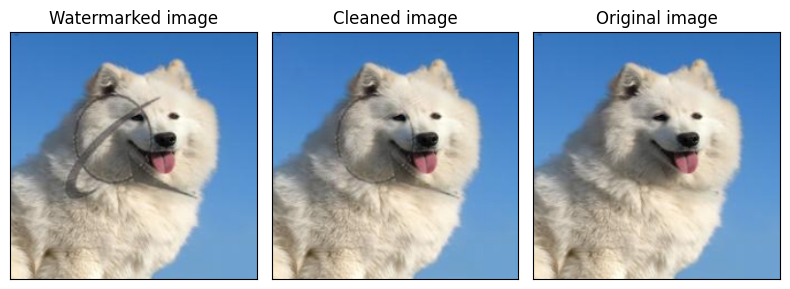

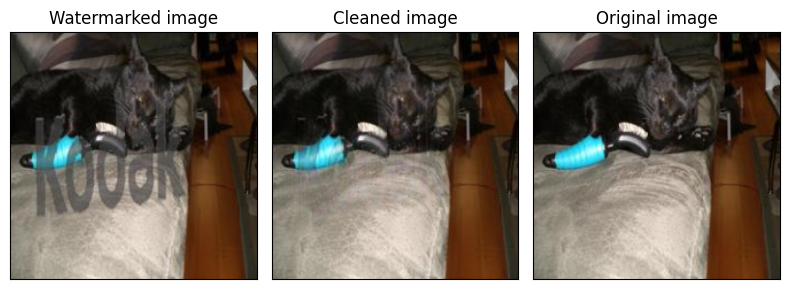

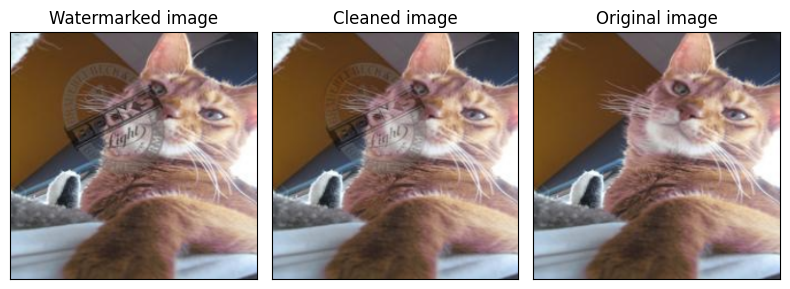

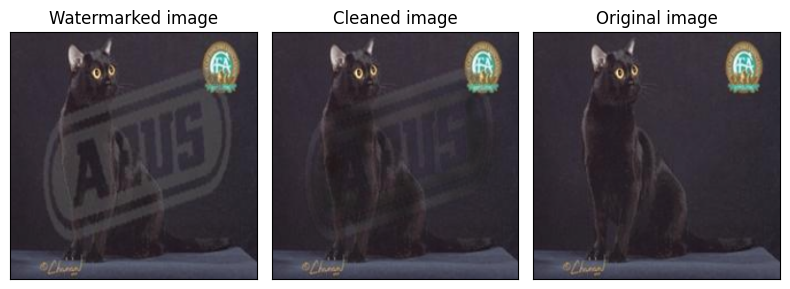

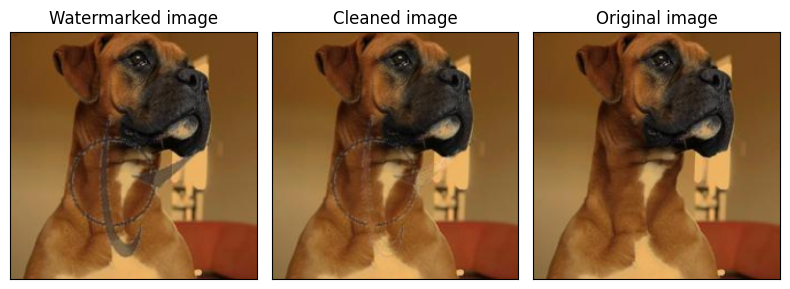

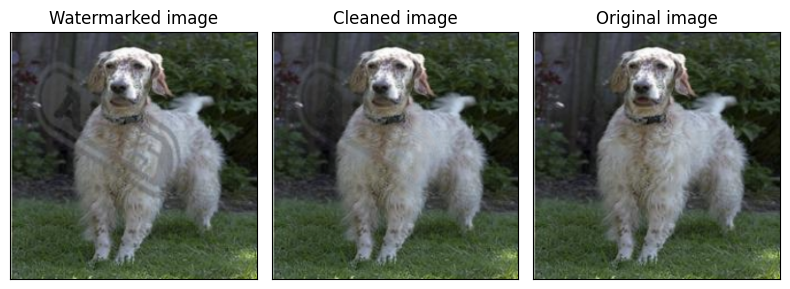

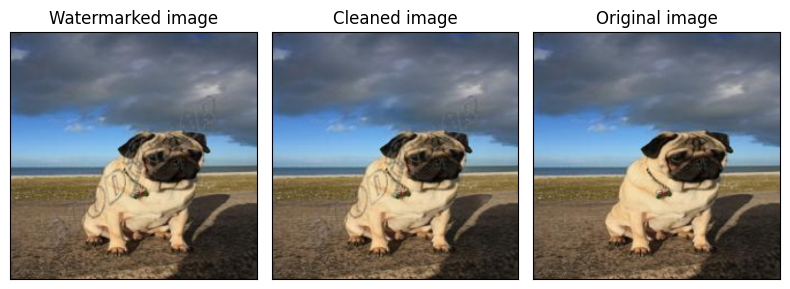

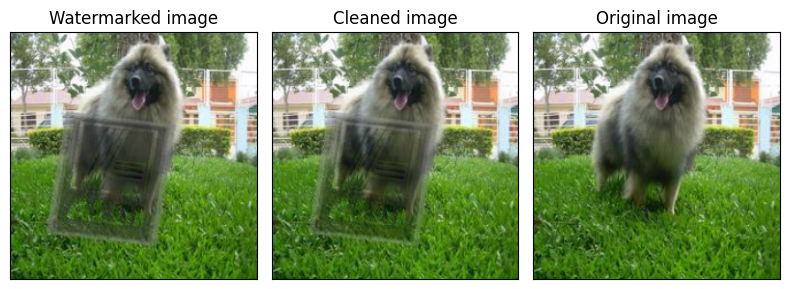

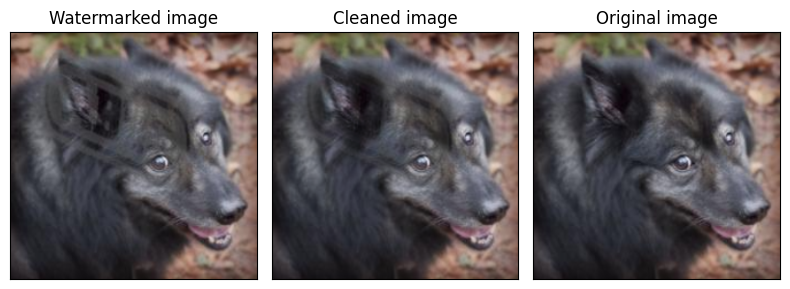

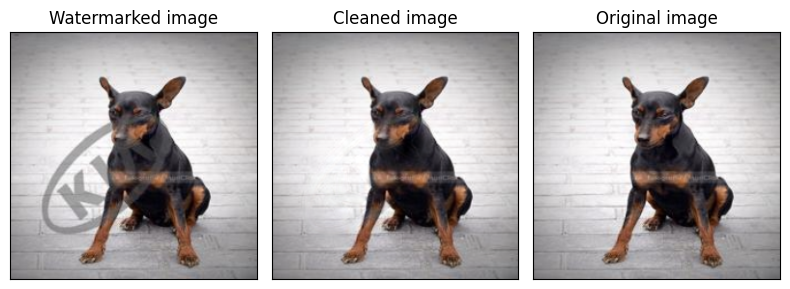

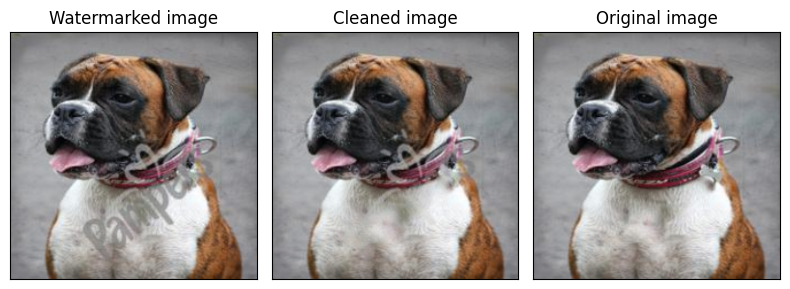

In [16]:
show_images_no = 32

for image_index in range(show_images_no):
    fig, axes = plt.subplots(1, 3, figsize=(8, 12))
    axes[0].imshow(images_with_watermark[image_index])
    axes[0].set_title("Watermarked image")
    axes[1].imshow(images_cleaned[image_index])
    axes[1].set_title("Cleaned image")
    axes[2].imshow(images_without_watermark[image_index])
    axes[2].set_title("Original image")

    for i in range(3):
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.tight_layout()

    plt.savefig(
        f"{results_path}/watermark_removal_sample_{image_index}_{IMAGE_LOGO_INSTANCES}{AUGMENTATION_STRATEGY}{TRANSPARENCY}.png", dpi=200, bbox_inches="tight"
    )
    plt.show()


### Store all test images with watermarks removed

In [17]:
cleaned_images_path = f"./data/images_cleaned_{IMAGE_LOGO_INSTANCES}{AUGMENTATION_STRATEGY}{TRANSPARENCY}"
if os.path.exists(cleaned_images_path):
    shutil.rmtree(cleaned_images_path)

os.mkdir(cleaned_images_path)
os.mkdir(cleaned_images_path + "/test/")

cleaned_images_paths = (
    test_data_w_watermark["image_path"].map(lambda x: x.replace(f"images_with_logos_5x{TRANSPARENCY}", f"images_cleaned_{IMAGE_LOGO_INSTANCES}{AUGMENTATION_STRATEGY}{TRANSPARENCY}")).to_list()
)

for image_index in range(len(cleaned_images_paths)):
    cleaned_to_store = Image.fromarray((images_cleaned[image_index] * 255).astype(np.uint8)).resize((224, 224))
    cleaned_to_store.save(cleaned_images_paths[image_index])